## Cristian Alejandro CHÁVEZ BECERRA

In [2]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

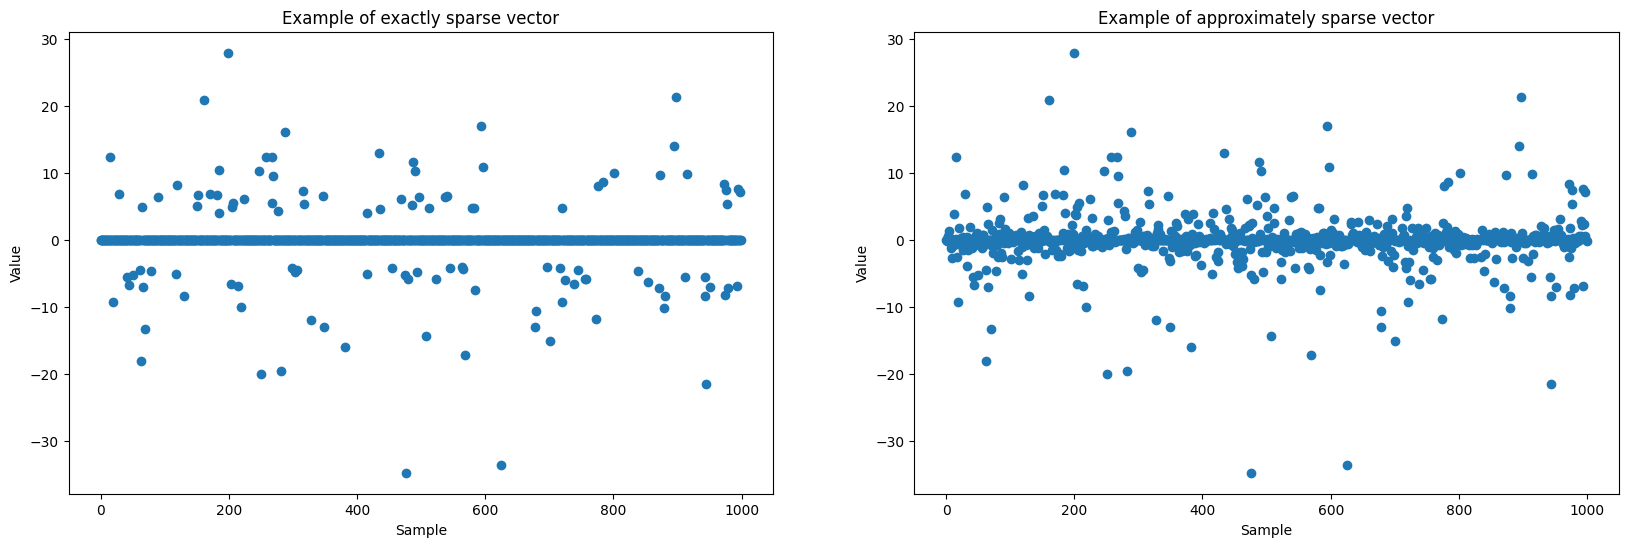

In [3]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

### Answer
Exact sparsity: A signal $s \in \mathbb{R}$ is said to be $k$-sparse if and only if $k$ of its elements are non-zero: $k \ll t$. That is $\| s \|_0 = k \ll t$, with the pseudo-norm $\| \cdot \|$ being the cardinality of the support of $s$.

Approximate sparsity:
Most real-life signals are not exactly sparse:

$$
\| s \|_0 \approx t
$$

Only a small number $k$ of the signal samples have a large amplitude.
=> the signal can be well approximated by a $k$-sparse signal.
This is for instance, if the sorted magnitudes of the signal samples follow a power law.


Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

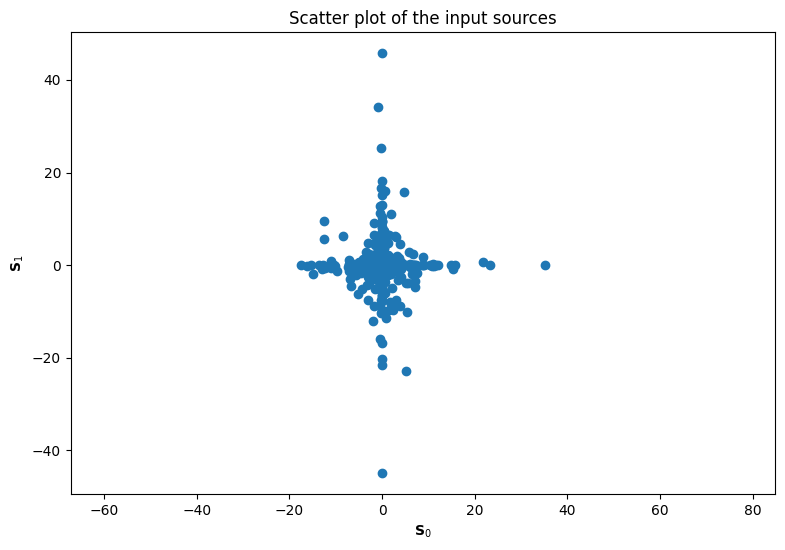

In [4]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = np.zeros((n, t))
for i in range(n):
  S[i] = np.random.randn(t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [5]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?
### Answer
• A shape where we can still, clearly see some axes of X. This is due to sparsity that the scatter plot of the abundances has a star shape. The changes in the direction of the axes of the abundances is because of its multiplication to the endmembers. Also we see less sparsity because of the mixing

What do the directions of the lines you observe correspond ?
### Answer
• The directions correspond to the endmembers' signatures. Each one with a different proportion defined by the mixing matrix A.

Try several A matrices, noise_values and powers. Any comment?
### Answer
• More the signal is sparse (with a greater value of power), less the noise impacts and the signal can be seperated in an easier way.

 With respect to A, changing the matrix values means changing the proportions of the endmembers of the scene which change the directions of the axes.

 Changing the level of noise impacts how clear the observations are. When noise levels are higher, distinguishing the true signal becomes harder since it's more obscured.


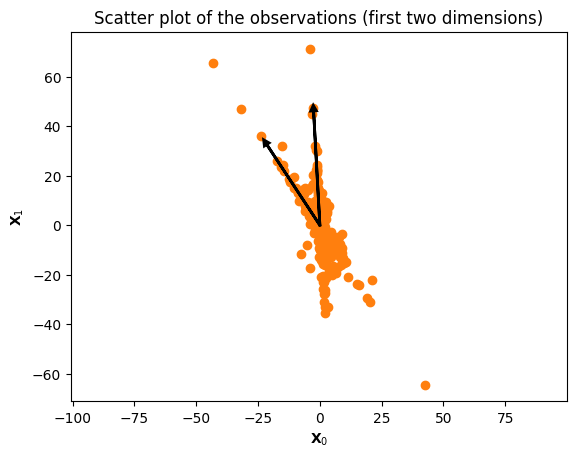

In [6]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

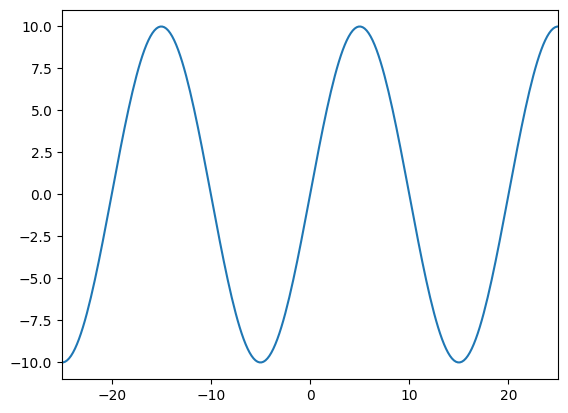

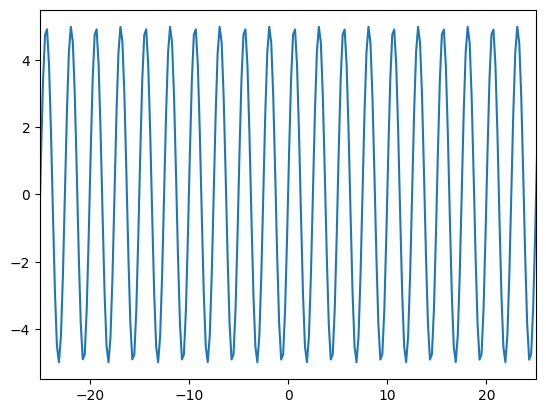

In [7]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

### Answer:
The objective of using the Discret Cosine Transform is to warp the signals into the frequency space that being able to describe the signal in their frequency components. Making it easier to identify them and so that, separate them.

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

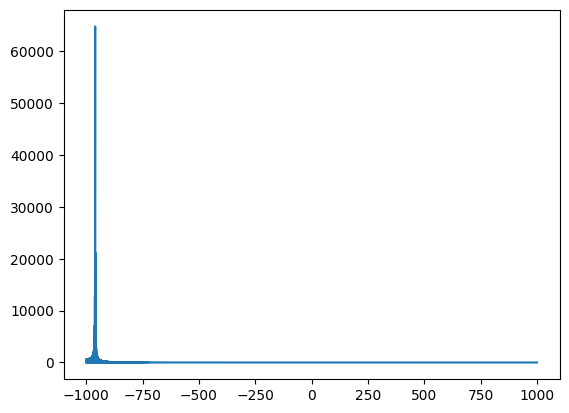

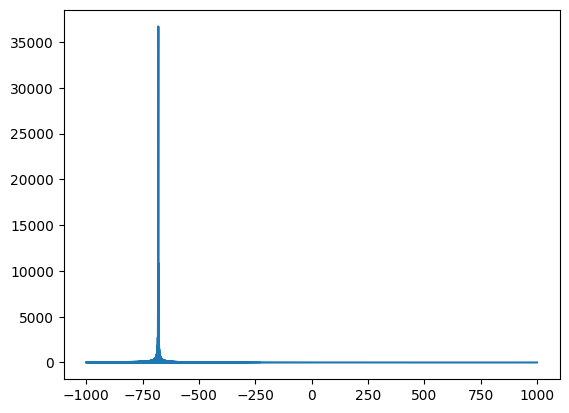

In [8]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.plot(x_abs, abs(Sf[0,:]))
plt.show()
plt.plot(x_abs, abs(Sf[1,:]))
plt.show()


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

### Answer
We see that the mixture of the signals (in different proportions given by the endmembers of the matrix A) with some noise added.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

### Answer
We can see that even the mixture of simple signals (as sin(x) signals) are hard to identify the original signals by sight. With the DCT of X we can see that the peaks of our mixture corresponds to the same frequencies of the peaks of both our original signals, just that in different proportions due to A and the noise. We could then use the inverse DCT in the dominant frequncies to recover our orginal signals, that is S



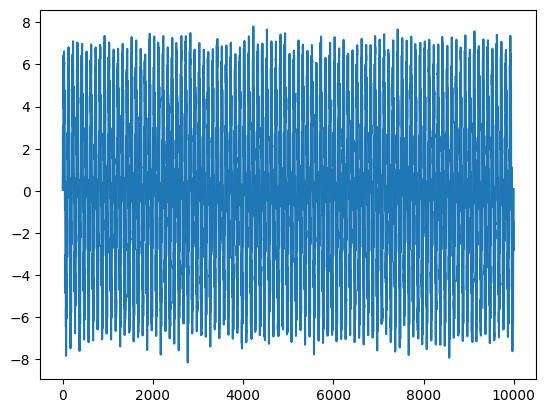

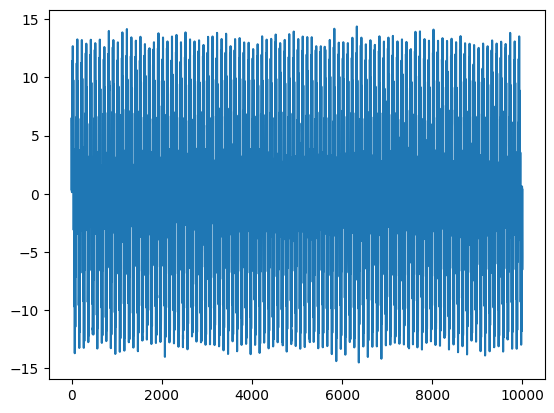

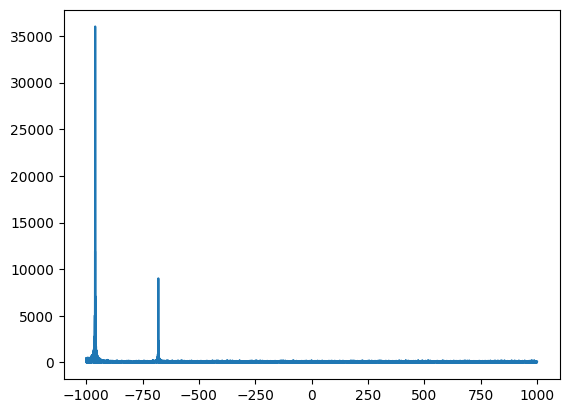

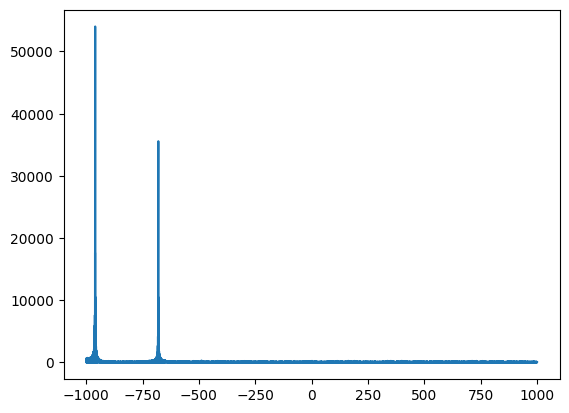

In [9]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

plt.plot(X[0,:])
plt.show()
plt.plot(X[1,:])
plt.show()

Xf = sff.dct(X)

plt.plot(x_abs, abs(Xf[0,:]))
plt.show()
plt.plot(x_abs, abs(Xf[1,:]))
plt.show()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

### Answer

To perform non-blind sparse source separation, we aim to minimize the following cost function using the Iterative Soft Thresholding Algorithm (ISTA):

$$
\min_{S} \frac{1}{2} \| X - AS \|_F^2 + \lambda \| S \|_1
$$

where:
- $X$ is the matrix of observations.
- $A$ is the mixing matrix, representing the linear relationship between sources and observations. (endemembers)
- $S$ is the matrix of source signals we aim to recover. (abundances)
- $\lambda$ is a regularization parameter that balances between data fidelity and sparsity regularization.

The term $\frac{1}{2} \| X - AS \|_F^2$ (data fidelity) measures the discrepancy between the observed data $X$ and the reconstructed data $AS$. This term is typically smooth.

The term $\| S \|_1$ (sparsity) promotes sparsity in the sources, encouraging many source coefficients to be exactly zero. This term is nonsmooth due to the absolute value operation in the $\ell_1$-norm but is convex.
  
So that, the cost function is convex, as it is the sum of a smooth and a nonsmooth convex functions.


Compute the gradient along the S variable of the data-fidelity term.

### Answer
$$f(S) = \frac{1}{2} \| X - AS \|_F^2$$

$$
\nabla_S f(S) = A^T(AS - X)
$$

Recall what the proximal operator of the l1-norm is.

### Answer

The proximal operator of the $\ell_1$-norm, denoted as $\text{prox}_{\lambda \|\cdot\|_1}$, is defined as:

$$
\text{prox}_{\lambda \|\cdot\|_1}(S_i) = \text{sign}(S_i) \cdot \max(|S_i| - \lambda, 0)
$$

or equivalently

$$
\text{prox}_{\lambda \|\cdot\|_1}(S_i) = \begin{cases}
S_i - \lambda, & \text{if } S_i > \lambda \\
0, & \text{if } |S_i| \leq \lambda \\
S_i + \lambda, & \text{if } S_i < -\lambda
\end{cases}
$$

In [10]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
#def prox_l1(S_est,thrd):
#  # To complete
#return S_est
def prox_l1(S_est, thrd):
    return np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)


Explain the main idea of the ISTA algorithm. Then, implement it.

The main idea behind the Iterative Soft Thresholding Algorithm (ISTA) is to iteratively minimize a cost function by performing a gradient descent-like update while applying a soft thresholding operation at each iteration. In our case ISTA is usefull to recover the sparse source signals by iteratively updating the estimate of the sources.

### ISTA Algorithm

1. **Initialize** $S$ (e.g., randomly or with zeros)
2. $\gamma = \frac{0.9}{||A^TA||}$
3. **For** $t = 1$ **to** $\text{k (number of iterations) }$:
   - Compute the gradient: $\nabla_S f(S) = - A^T(X - AS)$
   - Update $S$: $S \gets S_{\lambda\gamma}(S - \gamma \nabla_S f(S))$

4. **Return** $S$


In [11]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
#def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
#
#    return S_est
def ISTA(X, A=np.eye(2), n=2, lamb=0, nbIt=100):
    # Initialize estimate of sources
    S_est = np.zeros((A.shape[1], X.shape[1]))  # Initialize with zeros

    # Define step size (optional, you can also use a fixed step size)
    step_size = 0.9 / np.linalg.norm(A.T @ A, 2)

    # Iterate for nbIt iterations
    for _ in range(nbIt):
        # Compute gradient of the cost function
        grad = - A.T @ (X - A @ S_est)

        # Perform gradient descent step
        S_est -= step_size * grad

        # Apply soft thresholding to enforce sparsity
        S_est = prox_l1(S_est, lamb * step_size)

    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

### Answer
The higher the lambda value, the smaller is gonna be the recovered signal because the algorithm is gonna give more importance to the norm. The smaller the lambda value, we will recover highly irregular signals, which are noisy versions of the originals.



In [12]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)



Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

### Answer

They show approximate sparsity because they have limited support for the values above a certain intensity threshold

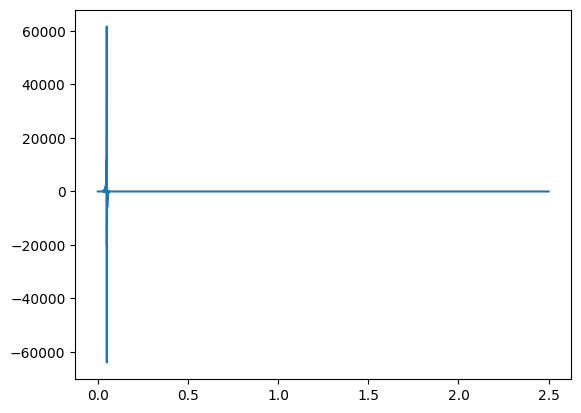

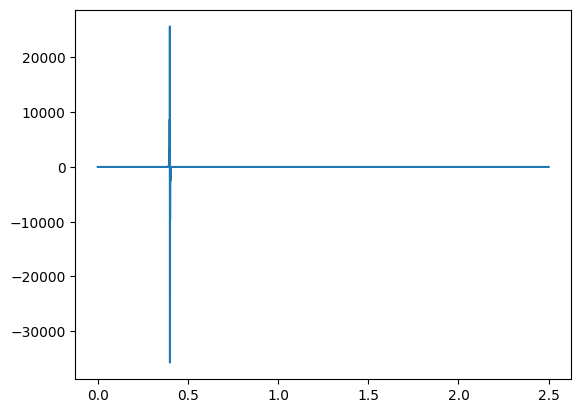

In [13]:
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[0,:])
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[1,:])

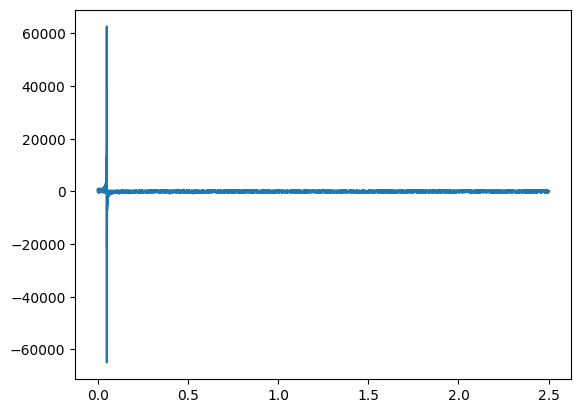

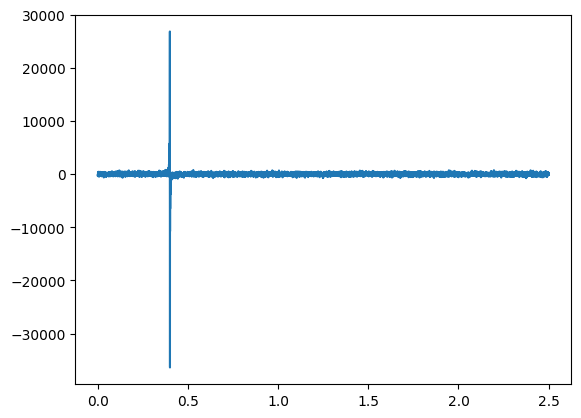

In [14]:
S_estf = ISTA(Xf,A = A,n=2,lamb=0.1,nbIt = 1000)
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[0,:])
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[1,:])

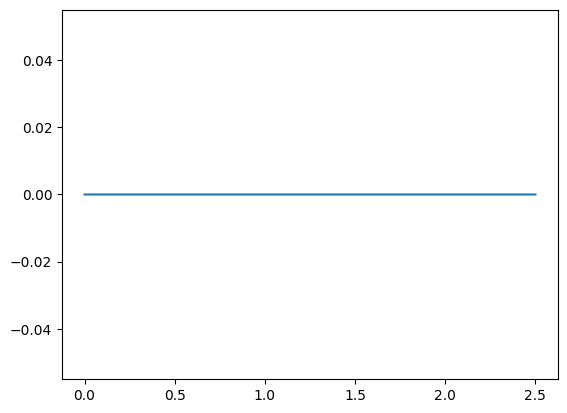

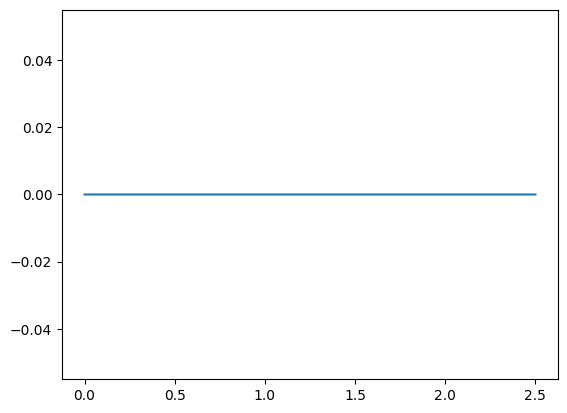

In [15]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000000,nbIt = 1000)
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[0,:])
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[1,:])

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

### Answer
We're able to succesfully recover the signal with the same frequency value using the proper value of lambda. The differences are in the amplitud, it seems to be our original signal times a multiplicative constant

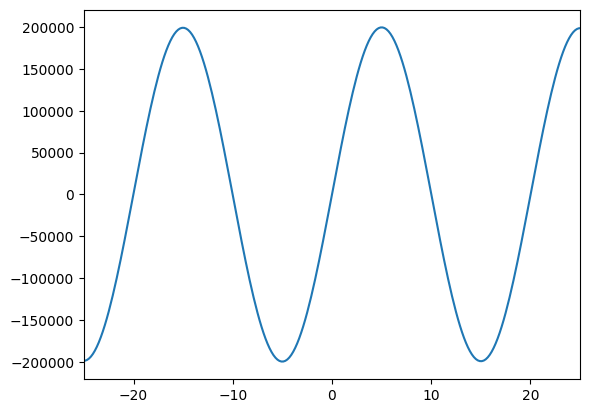

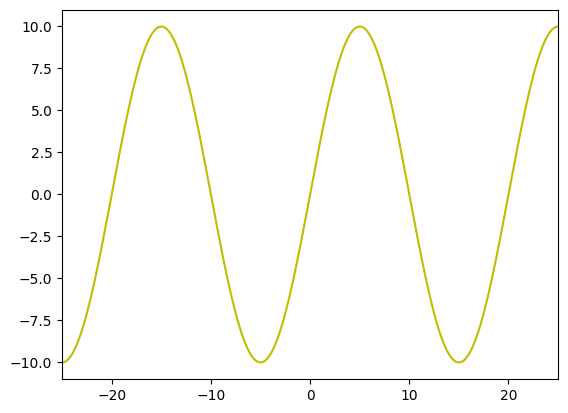

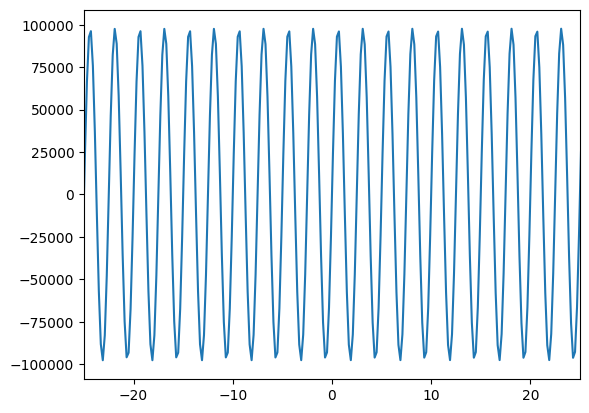

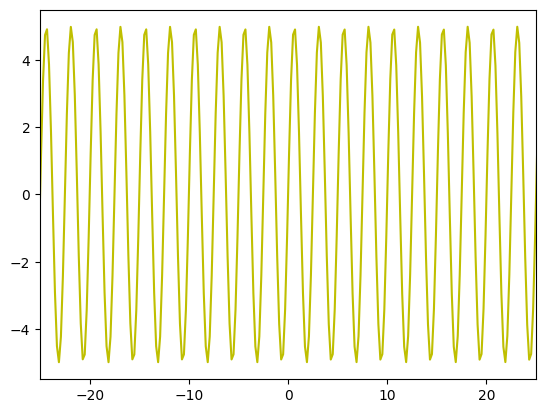

In [39]:
from scipy.fft import idct
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)
S_dir = sff.idct(S_estf)
plt.plot(x_abs, S_dir[0])
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[0], c='y')
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S_dir[1])
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[1], c='y')
plt.xlim([-25,25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

### Answer

$$
\min_{A \in \mathbb{R}^{m \times n}, \,\, S \in \mathbb{R}^{n \times t}} \,\, \frac{1}{2} \|X - AS\|_F^2 + \lambda \|S\|_1 + \iota_{\left\{ \forall i \in [1,n]; \left\| a_{:, j} \right\|_{\ell_2}^2 \leq 1 \right\}} (A)
$$
where:
- $X$ is the matrix of observations.
- $A$ is the mixing matrix, representing the linear relationship between sources and observations. (endemembers)
- $S$ is the matrix of source signals we aim to recover. (abundances)
- $\lambda$ is a regularization parameter that balances between data fidelity and sparsity regularization.

The term $\frac{1}{2} \| X - AS \|_F^2$ (data fidelity) measures the discrepancy between the observed data $X$ and the reconstructed data $AS$. This term is typically smooth.


The term $\| S \|_1$ (sparsity) promotes sparsity in the sources, encouraging many source coefficients to be exactly zero.


The new term is the oblique constraint. This causes that now we're dealing not only with a non-smooth function but at the same time a non-convex funciton




Recall what the gradient of the data fidelity term over A is.

### Answer

$$
\nabla_A \left( \frac{1}{2} \| X - AS \|_F^2 \right) = - (X - AS)S^T
$$

Compte the proximal operator of the oblique constraint. Implement it.

$$
\textit{prox}_{\iota_C} (s) = \min_{x \in C} \,\, \frac{1}{2} \|s - x\|_{\ell^2}^2
$$

Which is the Euclidian projection onto the unit ball.

In [24]:
def prox_oblique(A):
    for j in range(A.shape[1]):
      if np.linalg.norm(A[:, j]) > 1:
        A[:, j] /= np.linalg.norm(A[:, j])
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [25]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    m, t = X.shape

    A_est = np.random.randn(m, n)
    S_est = np.random.randn(n, t)
    k=0

    while k < nbIt:

        S_est = prox_l1(S_est + 0.9/np.linalg.norm(A_est.T @ A_est) * A_est.T @ (X - A_est @ S_est), lamb)


        A_est = prox_oblique(A_est + 0.9/np.linalg.norm(S_est @ S_est.T) * (X - A_est @ S_est) @ S_est.T)

        k+=1

    return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

### Answer
We can appreciate a good separation, and we see that both the original A and A_estimated matrices are pretty similar. However, these results highly depend on the parameters lambd and the numebr of iteraions.

If these values are too low, we can get more than one harmonic on the recovered signals, thus getting an linear combination of the sinusoids in the time domain. But if weincrease too much the value of lambda we're not able to recover a meaningful signal.

Original A = 
[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]

Estimated A = 
[[0.24397156 0.55494427]
 [0.96978239 0.83188752]]



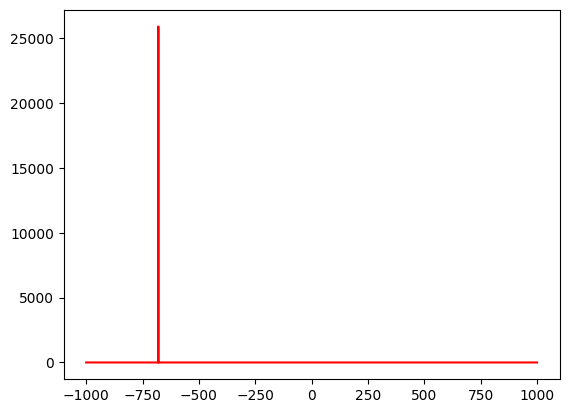

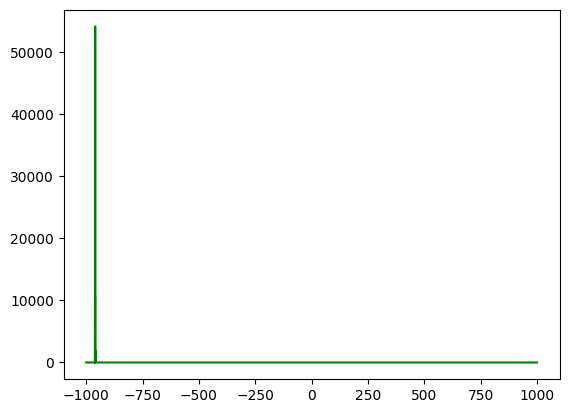

In [35]:
A_est, S_estp = PALM(Xf, n=2, lamb=5000, nbIt=1000)


print(f'Original A = \n{A}\n')
print(f'Estimated A = \n{A_est}\n')

plt.plot(x_abs, abs(S_estp[0,:]), c='r')
plt.show()
plt.plot(x_abs, abs(S_estp[1,:]), c='g')
plt.show()


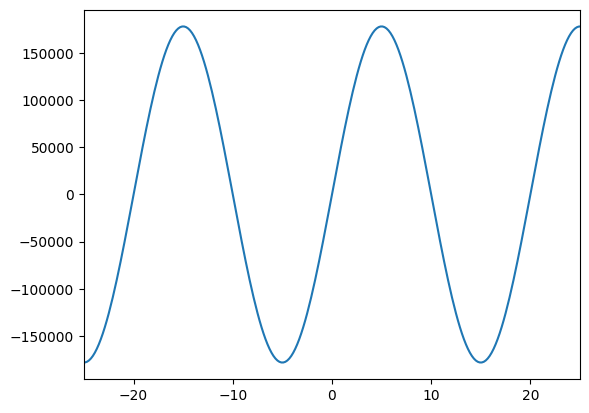

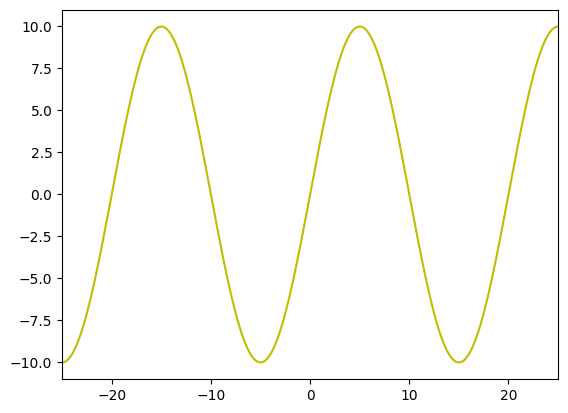

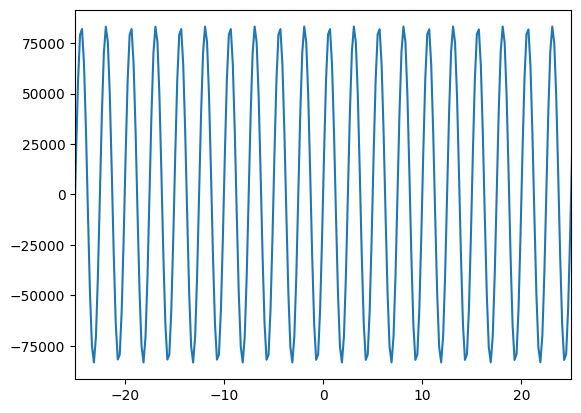

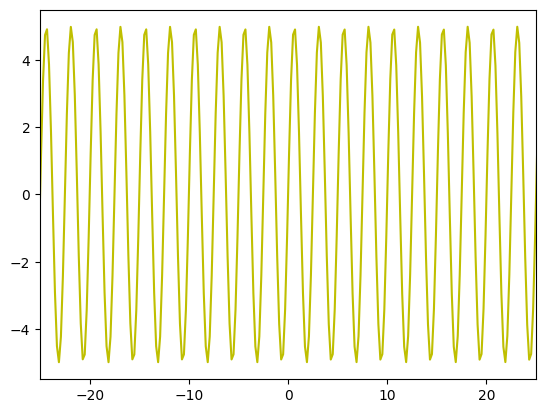

In [40]:
S_dir = sff.idct(S_estp)
plt.plot(x_abs, S_dir[1])
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[0], c='y')
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S_dir[0])
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[1], c='y')
plt.xlim([-25,25])
plt.show()